In [969]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import imageio
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import linalg as spla
from itertools import chain
import os


In [1132]:
def generateMesh():
    # Parameters for the square lattice and Gaussian noise
    lattice_size = 20
    spacing = 1.0
    noise_std = 0.2
    
    # Create the square lattice points
    x = np.arange(0, lattice_size, spacing)
    y = np.arange(0, lattice_size, spacing)
    xx, yy = np.meshgrid(x, y)
    points = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Identify interior points (i.e., not on the boundary)
    interior_mask = (xx > 0) & (xx < lattice_size - 1) & (yy > 0) & (yy < lattice_size - 1)
    
    # Create a new array to hold perturbed points, start with the original points
    noisy_points = points.copy()
    
    # Perturb only the interior points with Gaussian noise
    noisy_points[interior_mask.ravel()] += np.random.normal(scale=noise_std, size=noisy_points[interior_mask.ravel()].shape)

    tri = Delaunay(noisy_points)

    edgeList = set()
    for simplex in tri.simplices:
        # points = noisy_points[simplex].tolist()
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i+1) % 3]]))
            edgeList.add(edge)
    edgeList = np.array(list(edgeList))

    return noisy_points, edgeList, tri


# def genMat():
#     N = 20
#     R_max = 10
#     noise_std = 0.2
    
#     # Create the square lattice points
#     rList = np.linspace(0,R_max,N)
#     thetaList = np.linspace(0,2*np.pi,N)
#     RR, ThetaTheta = np.meshgrid(rList, thetaList)
#     X = RR*np.cos(ThetaTheta)
#     Y = RR*np.sin(ThetaTheta)
#     points = np.vstack([X.ravel(), Y.ravel()]).T
    
#     # Identify interior points (i.e., not on the boundary)
#     interior_mask = (points < 0.9*R_max) 
    
#     # Create a new array to hold perturbed points, start with the original points
#     noisy_points = points.copy()
    
#     # Perturb only the interior points with Gaussian noise
#     noisy_points[interior_mask.ravel()] += np.random.normal(scale=noise_std, size=noisy_points[interior_mask.ravel()].shape)

#     tri = Delaunay(noisy_points)

#     edgeList = set()
#     for simplex in tri.simplices:
#         # points = noisy_points[simplex].tolist()
#         for i in range(3):
#             edge = tuple(sorted([simplex[i], simplex[(i+1) % 3]]))
#             edgeList.add(edge)
#     edgeList = np.array(list(edgeList))

#     return noisy_points, edgeList, tri
    


def generateMeshOnDisk_Random():
    # Parameters for the disk and Gaussian noise
    num_points = 400
    radius = 10
    noise_std = 0.0

    # Generate random points in polar coordinates for a disk
    r = radius * np.sqrt(np.random.rand(num_points))  # Radius (scaled for uniformity on the disk)
    # r = radius * np.linspace(0,1,num_points)
    theta = np.random.rand(num_points) * 2 * np.pi    # Angle in radians
    # theta = np.linspace(0,np.pi*2,num_points)

    # Convert polar coordinates to Cartesian coordinates
    points = np.vstack([r * np.cos(theta), r * np.sin(theta)]).T

    # Find points that are "interior" (e.g., far from the boundary)
    # Consider points far from the boundary of the disk (say, 95% of radius)
    interior_mask = r < (0.9 * radius)
    
    # Perturb only the interior points with Gaussian noise
    noisy_points = points.copy()
    noisy_points[interior_mask] += np.random.normal(scale=noise_std, size=noisy_points[interior_mask].shape)

    # Perform Delaunay triangulation on the noisy points
    tri = Delaunay(noisy_points)

    # Create edge list from Delaunay simplices
    edgeList = set()
    for simplex in tri.simplices:
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i+1) % 3]]))
            edgeList.add(edge)
    edgeList = np.array(list(edgeList))

    return noisy_points, edgeList, tri


def generateMeshOnDisk_Uniform():
    # Parameters for the disk and Gaussian noise
    num_r_points = 20   # Number of points along the radial direction
    num_theta_points = 20  # Number of points along the angular direction
    radius = 10
    noise_std = 0.3  # Perturbation amount

    # Generate uniform meshgrid of r and theta
    r = np.linspace(0.1*radius, radius, num_r_points)  # Uniform points in radial direction
    theta = np.linspace(0, 2 * np.pi, num_theta_points)  # Uniform points in angular direction
    
    # Create meshgrid
    rr, tt = np.meshgrid(r, theta)
    
    # Convert polar coordinates (r, theta) to Cartesian coordinates (x, y)
    xx = rr * np.cos(tt)
    yy = rr * np.sin(tt)
    
    # Stack to create a list of points
    points = np.vstack([xx.ravel(), yy.ravel()]).T
    
    # Find points that are "interior" (e.g., within 90% of the radius)
    interior_mask = rr.ravel() < (0.95 * radius)
    
    # Perturb only the interior points with Gaussian noise
    noisy_points = points.copy()
    noisy_points[interior_mask] += np.random.normal(scale=noise_std, size=noisy_points[interior_mask].shape)

    # Perform Delaunay triangulation on the noisy points
    tri = Delaunay(noisy_points)

    # Create edge list from Delaunay simplices
    edgeList = set()
    for simplex in tri.simplices:
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i+1) % 3]]))
            edgeList.add(edge)
    edgeList = np.array(list(edgeList))

    return noisy_points, edgeList, tri




def generateGraph(edge, nodes):
    G = nx.Graph()
    pos = {}
    
    for i,edge in enumerate(edges):
        node = nodes[edge]
        for j in range(2):
            G.add_node(edge[j],pos=node[j],p=0.0,s=0.0)
            pos[edge[j]] = node[j]
        G.add_edge(edge[0],edge[1],C=np.random.random()*0+1.0,Q=0.0)

    return G,pos

def calculateVolume():
    total_volume = 0

    for u, v in G.edges():
        # Get the positions of the nodes
        pos_u = np.array(G.nodes[u]['pos'])
        pos_v = np.array(G.nodes[v]['pos'])
        # Calculate the distance (L) between the nodes
        L = np.linalg.norm(pos_u - pos_v)
        # Get the conductance (C) of the edge
        C = G.edges[u, v]['C']
        # Calculate the volume of the edge and add to total
        total_volume += L * np.sqrt(C)

    return total_volume

def g(Q):
    return np.abs(Q)**(2/3)

def calculateFlow():
    L = nx.laplacian_matrix(G,weight="C") # Convert to a dense NumPy array if needed

    # Perturb the diagonal entry of the Laplacian matrix for one of the sink nodes
    sink_node = sinkNodes[np.random.randint(N_sink)]  # Choose one sink node for perturbation
    L = L.tolil()  # Convert to LIL format to modify the sparse matrix
    L[sink_node, sink_node] += 1e-5# Add a small constant to the diagonal
    L = L.tocsr()  # Convert back to CSR format for efficient solving
    
    S = np.array([G.nodes[n]['s'] for n in G.nodes()])
    P = spla.spsolve(L,S)

    # Assign pressures back to the graph nodes
    for i, n in enumerate(G.nodes()):
        G.nodes[n]['p'] = P[i]
    
    for u,v in G.edges():
        C = G.edges[u,v]["C"]
        pos_u = np.array(G.nodes[u]['pos'])
        pos_v = np.array(G.nodes[v]['pos'])
        L = np.linalg.norm(pos_u - pos_v)
        G.edges[u,v]["Q"] = C * (G.nodes[u]["p"] - G.nodes[v]["p"])/L

# def calculateFlow():
#     # Construct Laplacian matrix based on the edge weights "C"
#     L = nx.laplacian_matrix(G, weight="C")  # Sparse matrix
    
#     # Perturb the diagonal entry of the Laplacian matrix for one of the sink nodes
#     sink_node = sinkNodes[np.random.randint(N_sink)]  # Choose a random sink node
#     L = L.tolil()  # Convert to LIL format to modify the sparse matrix
#     L[sink_node, sink_node] += 1e-5  # Add a small constant to the diagonal of the sink node
#     L = L.tocsr()  # Convert back to CSR format for efficient solving

#     # Construct the source vector S using the same order as nodes in G.nodes()
#     S = np.array([G.nodes[n]['s'] for n in G.nodes()])

#     # Solve for pressure vector P using the Laplacian matrix and source vector
#     P = spla.spsolve(L, S)

#     # Assign pressures back to the graph nodes
#     for i, n in enumerate(G.nodes()):
#         G.nodes[n]['P'] = P[i]

#     # Calculate flow for each edge using the pressure difference
#     for u, v in G.edges():
#         C = G.edges[u, v]["C"]  # Conductance
#         pos_u = np.array(G.nodes[u]['pos'])  # Position of node u
#         pos_v = np.array(G.nodes[v]['pos'])  # Position of node v
#         L = np.linalg.norm(pos_u - pos_v)  # Length of the edge (distance between nodes)
#         Q = C * (P[u] - P[v]) / L  # Flow calculation
#         G.edges[u, v]["Q"] = Q  # Assign the flow to the edge



def updateConductance():
    C = np.array([G.edges[edge]['C'] for edge in G.edges()])
    Q = np.array([G.edges[edge]['Q'] for edge in G.edges()])
    A = 0
    for u, v in G.edges():
        pos_u = np.array(G.nodes[u]['pos'])
        pos_v = np.array(G.nodes[v]['pos'])
        L = np.linalg.norm(pos_u - pos_v)
        A += L*g(G.edges[u,v]["Q"])
    
    C = ( np.sqrt(C) + dt * (V/beta*(g(Q)/A)-mu*np.sqrt(C)) )**2

    for edge, new_conductance in zip(G.edges(), C):
        G.edges[edge]['C'] = new_conductance

    
# # Plot the results
# plt.figure(figsize=(6, 6))
# plt.triplot(nodes[:, 0], nodes[:, 1], tri.simplices, color='b')
# plt.plot(nodes[:, 0], nodes[:, 1], 'ro')
# plt.gca().set_aspect('equal')
# plt.title('Delaunay Triangulation with Perturbed Interior Points')
# plt.show()
    


In [1140]:
dt = 0.1
beta = 1
mu=1

In [1141]:
# nodes, edges, tri = generateMesh()
nodes, edges, tri = generateMeshOnDisk_Random()
# nodes, edges, tri = generateMeshOnDisk_Uniform()


G,pos = generateGraph(edges,nodes)
N_source = 1
N_sink = 10
sinkNodes = np.random.choice(G.nodes(), N_sink, replace=False)
sourceNodes = np.random.choice(G.nodes(), N_source, replace=False)
for n in sourceNodes:
    G.nodes[n]["s"] = 1/N_source
for n in sinkNodes:
    G.nodes[n]["s"] = -1/N_sink

V = calculateVolume()

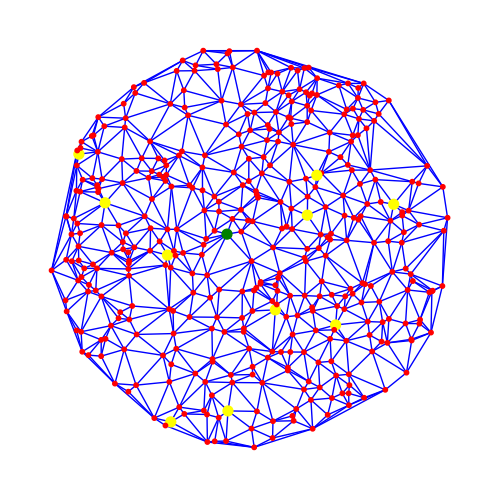

In [1142]:
edge_widths = [(G.edges[u, v]['C'])**(1/4)for u, v in G.edges()]
node_colors = ['green' if n in sourceNodes else 'yellow' if n in sinkNodes else 'red' for n in G.nodes()]
node_sizes = [50 if n in sourceNodes or n in sinkNodes else 10 for n in G.nodes()]

nx.draw(G, pos, width=edge_widths, with_labels=False, node_color=node_colors, edge_color='blue', node_size=node_sizes)
plt.gca().set_aspect('equal')
plt.show()

In [1143]:
# gif_filename = "graph_evolution.gif"
# images = []

# # Create a temporary folder to store frames
# if not os.path.exists('frames'):
#     os.makedirs('frames')

# node_colors = ['green' if n in sourceNodes else 'yellow' if n in sinkNodes else 'red' for n in G.nodes()]
# node_sizes = [50 if n in sourceNodes or n in sinkNodes else 10 for n in G.nodes()]
for i in range(70):
    calculateFlow()
    updateConductance()
    
    # edge_widths = [(G.edges[u, v]['C'])**(1/4) for u, v in G.edges()]
    # nx.draw(G, pos, width=edge_widths, with_labels=False, node_color=node_colors, edge_color='blue', node_size=node_sizes)
    # nx.draw(G, pos, width=1, with_labels=False, node_color=node_colors, edge_color='orange',alpha=0.2, node_size=node_sizes)
    # plt.gca().set_aspect('equal')
    # plt.title(i)

    # # Save the frame as an image
    # plt.savefig(f'frames/frame_{i}.png')
    # plt.close()
    
    # # Append the image to the list
    # images.append(imageio.imread(f'frames/frame_{i}.png'))


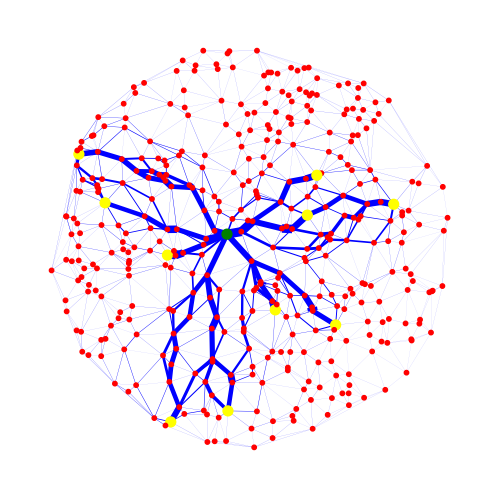

In [1144]:
edge_widths = [(G.edges[u, v]['C'])**(1/4) for u, v in G.edges()]
# Normalize conductances to a range of 0.5 to 5
node_colors = ['green' if n in sourceNodes else 'yellow' if n in sinkNodes else 'red' for n in G.nodes()]
node_sizes = [50 if n in sourceNodes or n in sinkNodes else 10 for n in G.nodes()]
nx.draw(G, pos, width=edge_widths, with_labels=False, node_color=node_colors, edge_color='blue', node_size=node_sizes)
# nx.draw(G, pos, width=1, with_labels=False, node_color=node_colors, edge_color='orange',alpha=0.2, node_size=node_sizes)
plt.gca().set_aspect('equal')

plt.show()

In [1138]:
# imageio.mimsave(gif_filename, images, fps=10)

# # Optionally, clean up the frames folder after creating the GIF
# import shutil
# shutil.rmtree('frames')

# # Plot the final version of the graph
# nx.draw(G, pos, width=edge_widths, with_labels=False, node_color=node_colors, edge_color='blue', node_size=node_sizes)
# nx.draw(G, pos, width=1, with_labels=False, node_color=node_colors, edge_color='orange', alpha=0.2, node_size=node_sizes)
# plt.gca().set_aspect('equal')
# plt.show()

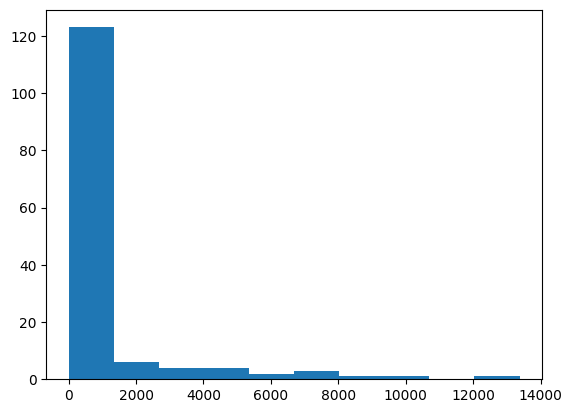

In [1087]:
CList = np.array([G.edges[n]["C"] for n in G.edges()])
_=plt.hist(CList[CList>1])


In [962]:
CList[CList>0]

array([2.42592619e-06, 4.01052969e-03, 1.29607313e-05, ...,
       3.53033003e-07, 5.07065559e-07, 1.00467953e-05])

## TESTs

In [ ]:
# # Plot the results
# plt.figure(figsize=(6, 6))
# plt.triplot(nodes[:, 0], nodes[:, 1], tri.simplices, color='b')
# plt.plot(nodes[:, 0], nodes[:, 1], 'ro')
# plt.gca().set_aspect('equal')
# plt.title('Delaunay Triangulation with Perturbed Interior Points')
# plt.show()

In [233]:
g = nx.Graph()
for i in range(1,6):
    g.add_node(i)

g.add_edge(1,2,w=1)
g.add_edge(1,3,w=2)
g.add_edge(2,3,w=3)
g.add_edge(2,5,w=5)
g.add_edge(4,5,w=5)

In [234]:
nx.adjacency_matrix(g,weight="w").toarray()

/tmp/ipykernel_547115/3488527025.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(g,weight="w").toarray()


array([[0, 1, 2, 0, 0],
       [1, 0, 3, 0, 5],
       [2, 3, 0, 0, 0],
       [0, 0, 0, 0, 5],
       [0, 5, 0, 5, 0]])

In [251]:
mat = nx.laplacian_matrix(g,weight="w").toarray()
mat[1,1]+=1

In [252]:
mat

array([[ 3, -1, -2,  0,  0],
       [-1, 10, -3,  0, -5],
       [-2, -3,  5,  0,  0],
       [ 0,  0,  0,  5, -5],
       [ 0, -5,  0, -5, 10]])

In [253]:
np.linalg.det(mat)

274.9999999999996